# Masking

In [1]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import jax.random as jrandom
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from loguru import logger
import kernex as kex
from jaxsw._src.domain.mask import Mask

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    logger.debug(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}" +
        f" {quantity.dtype}"
    )

```python
mask: GeoDataFrame = ...
mask: Array = polygon_to_array(mask)

mask_q

```

psi --- q --- psi --- q --- psi --- q --- psi
land          water         water        land
false.        true.         true.        false
       true          true.         true

psi --- q --- psi --- q --- psi --- q --- psi
land          water         water        land
false.        true.         true.        false
       true          true.         true

## Initialization From Psi

In [12]:
n = 8
mask = jnp.ones((n,n))
mask = mask.at[0].set(0.0)
mask = mask.at[-1].set(0.0)
# mask = mask.at[:,0].set(0.0)
mask = mask.at[:,-1].set(0.0)
mask = mask.at[2:-2,2:-2].set(0.0)

In [13]:
masks = Mask.init_mask(mask, "psi")

In [14]:
masks.q, masks.psi

(Array([[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]], dtype=float64),
 Array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float64))

## Visualization

[None, None, None, None, None, None, None, None, None]

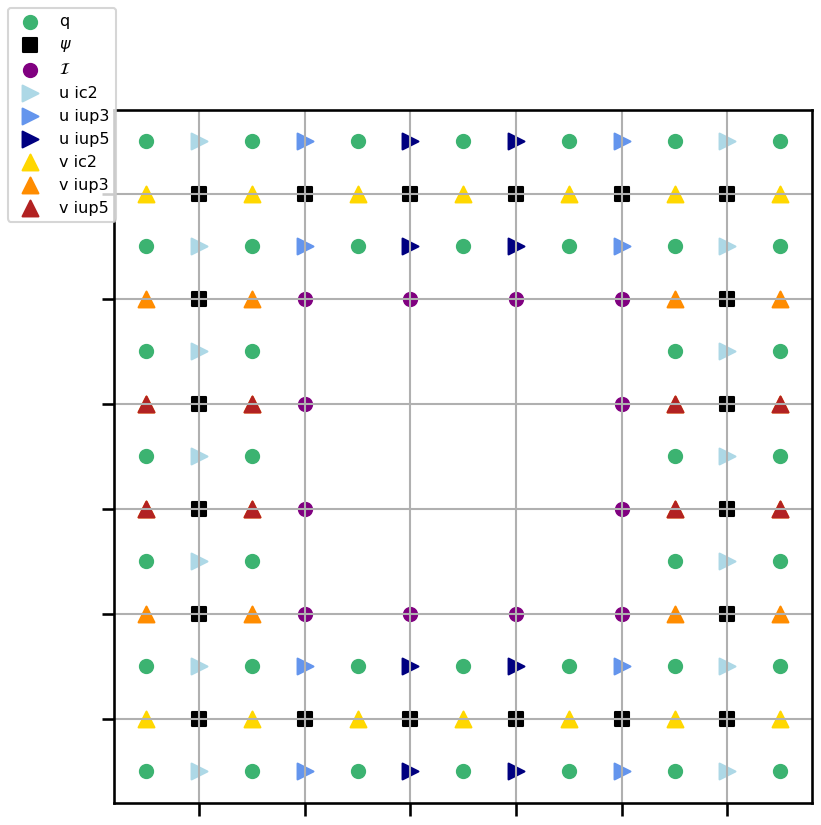

In [7]:

plt.ion()
f,a =plt.subplots(figsize=(9,9))
# a.imshow(mask.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1)
a.set_xticks(np.arange(-0.5,n+0.5)), a.set_yticks(np.arange(-0.5,n+0.5))
a.grid()

s = 90
s2 = 130
q_xmin, q_ymin = 0, 0
mask_q_ids = jnp.argwhere(masks.q.squeeze())
a.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
            s=s, marker='o', label='q', color='mediumseagreen')

psi_xmin, psi_ymin = -.5, -.5
mask_psi_ids = jnp.argwhere(masks.psi.squeeze())
a.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
          s=s, marker='s', label='$\\psi$', color='black')
a.scatter(psi_xmin+1+masks.psi_irrbound_xids,psi_ymin+1+masks.psi_irrbound_yids,
          s=s, marker='o', label='$\mathcal{I}$', color='purple')

u_xmin, u_ymin = -.5, 0
mask_u_ids = jnp.argwhere(masks.u_distbound1.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u ic2', color='lightblue')
mask_u_ids = jnp.argwhere(masks.u_distbound2.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup3', color='cornflowerblue')
mask_u_ids = jnp.argwhere(masks.u_distbound3plus.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup5', color='navy')

v_xmin, v_ymin = 0, -.5
mask_v_ids = jnp.argwhere(masks.v_distbound1.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v ic2', color='gold')
mask_v_ids = jnp.argwhere(masks.v_distbound2plus.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup3', color='darkorange')
mask_v_ids = jnp.argwhere(masks.v_distbound3plus.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup5', color='firebrick')



f.legend(loc='upper left')
plt.setp(a.get_xticklabels(), visible=False)
plt.setp(a.get_yticklabels(), visible=False)

In [8]:
n = 7
mask = jnp.ones((n,n))
# mask = mask.at[:2].set(0.0)
# mask = mask.at[-2:].set(0.0)
# mask = mask.at[:,0].set(0.0)
# mask = mask.at[:,-2].set(0.0)
mask = mask.at[2:-2,2:-2].set(0.0)

In [9]:
masks = Mask.init_mask(mask, "q")

In [10]:
masks.q, masks.psi

(Array([[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]], dtype=float64),
 Array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float64))

[None, None, None, None, None, None, None, None]

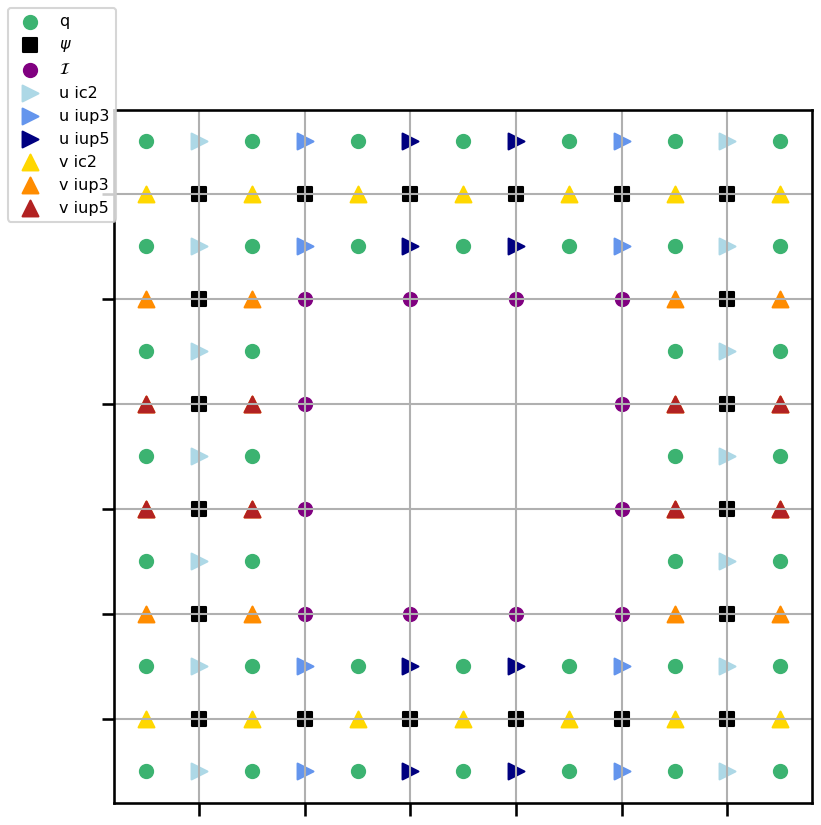

In [11]:

plt.ion()
f,a =plt.subplots(figsize=(9,9))
# a.imshow(mask.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1)
a.set_xticks(np.arange(-0.5,n+0.5)), a.set_yticks(np.arange(-0.5,n+0.5))
a.grid()

s = 90
s2 = 130
q_xmin, q_ymin = 0, 0
mask_q_ids = jnp.argwhere(masks.q.squeeze())
a.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
            s=s, marker='o', label='q', color='mediumseagreen')

psi_xmin, psi_ymin = -.5, -.5
mask_psi_ids = jnp.argwhere(masks.psi.squeeze())
a.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
          s=s, marker='s', label='$\\psi$', color='black')
a.scatter(psi_xmin+1+masks.psi_irrbound_xids,psi_ymin+1+masks.psi_irrbound_yids,
          s=s, marker='o', label='$\mathcal{I}$', color='purple')

u_xmin, u_ymin = -.5, 0
mask_u_ids = jnp.argwhere(masks.u_distbound1.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u ic2', color='lightblue')
mask_u_ids = jnp.argwhere(masks.u_distbound2.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup3', color='cornflowerblue')
mask_u_ids = jnp.argwhere(masks.u_distbound3plus.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup5', color='navy')

v_xmin, v_ymin = 0, -.5
mask_v_ids = jnp.argwhere(masks.v_distbound1.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v ic2', color='gold')
mask_v_ids = jnp.argwhere(masks.v_distbound2plus.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup3', color='darkorange')
mask_v_ids = jnp.argwhere(masks.v_distbound3plus.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup5', color='firebrick')



f.legend(loc='upper left')
plt.setp(a.get_xticklabels(), visible=False)
plt.setp(a.get_yticklabels(), visible=False)